In [2]:
import gym
import numpy as np
from IPython import display
import matplotlib.pyplot as plt
from envs import Maze
from utils import plot_policy , plot_values , test_agent , plot_action_values
%matplotlib inline

# Getting Familiar with the Environment

In [2]:
env = Maze()

In [3]:
initial_state = env.reset()
print(f"state : {initial_state}")

state : (0, 0)


C:\ProgramData\Anaconda3\envs\vrep\lib\site-packages\gym\core.py:51: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


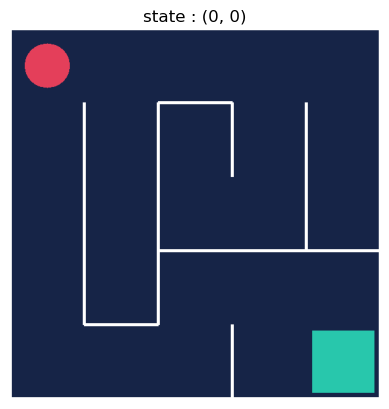

In [4]:
frame = env.render(mode='rgb_array')
plt.axis('off')
plt.title(f"state : {initial_state}")
plt.imshow(frame)

In [5]:
## Action =>  0:up , 1:right , 2:down , 3:left
a=2
next_state , reward , done , info = env.step(a)
print(next_state , reward , done , info)

(1, 0) -1.0 False {}


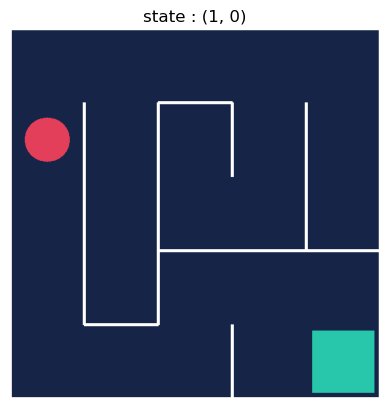

In [6]:
frame = env.render(mode='rgb_array')
plt.axis('off')
plt.title(f"state : {next_state}")
plt.imshow(frame)

In [7]:
env.close()

# Solving the Maze with MDP

In [8]:
env = Maze()
## Action =>  0:up , 1:right , 2:down , 3:left
## State-space => 5X5 =>  {0,1,2,3,4} X {0,1,2,3,4}
print(f"action-space : {env.action_space}")
print(f"state-space : {env.observation_space}")
env.close()

action-space : Discrete(4)
state-space : MultiDiscrete([5 5])


In [9]:
# Lets Create Episode: S0,A0,R1,S1,A1,...,RT,ST
env = Maze()
state = env.reset()
episode =[]
gamma=0.99
G=0
t=0
done=False
while not done :
    action = env.action_space.sample()
    next_state , reward , done , info = env.step(action)
    episode.append([state , action , reward , next_state])
    state = next_state
    G = G + (gamma**t)*reward
    t = t+1
env.close()  
print(f"num episodes : {t} , return : {G}")

num episodes : 888 , return : -99.98669383812158


# Value Iteration

In [10]:
env = Maze()
env.reset()
frame = env.render(mode='rgb_array')
policy_probs = np.full ((5,5,4) , 0.25) # 25 states , 4 possible transition for each

def policy (state) :
    return policy_probs[state]

## test the policy function :
policy((0,0))

array([0.25, 0.25, 0.25, 0.25])

KeyboardInterrupt: 

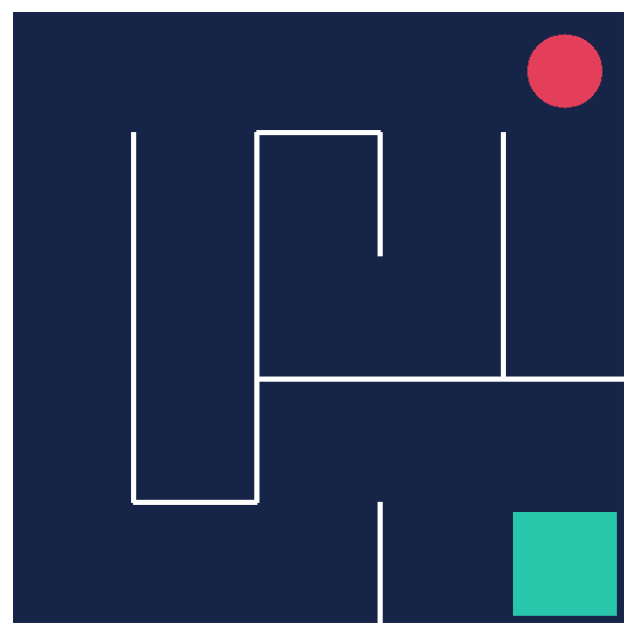

In [11]:
# test the random policy to solve the Maze:
test_agent(env , policy , episodes = 1 )

C:\Users\Ali\Documents\RLwithPhil\code\utils.py:23: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  probs_copy = max_prob_actions.copy().astype(np.object)


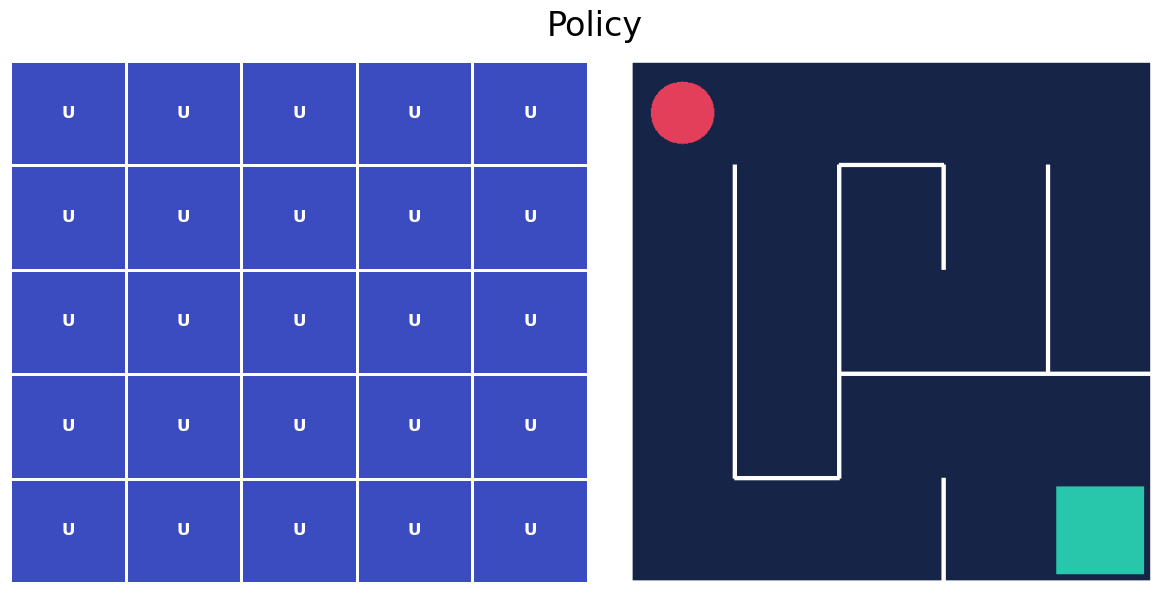

In [12]:
# plotting the policy:
plot_policy (policy_probs , frame)

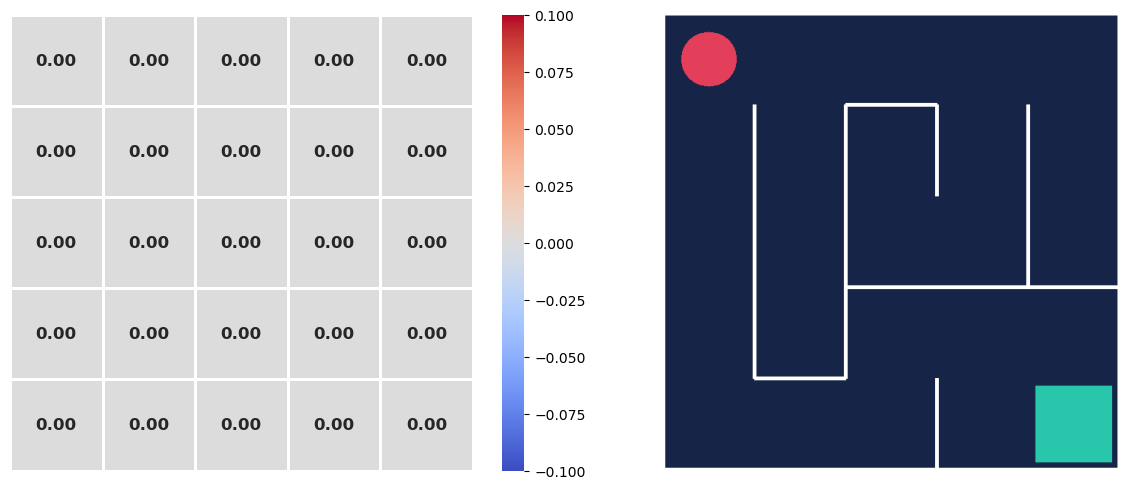

In [13]:
# Value Iteration : INITILIZE V(s)
state_values = np.zeros((5,5))
plot_values(state_values , frame)

In [14]:
# Value Iteration :
def value_iteration(policy_probs , state_values , theta = 1e-6 , gamma=0.99):
    delta = float('inf')
    while delta > theta:
        delta=0 
        for row in range(5):
            for col in range(5):
                old_value=state_values[(row,col)]
                action_probs = None
                max_qsa = float('-inf')
                
                for action in range(4):
                    next_state , reward , done , info = env.simulate_step((row,col),action)
                    qsa = reward + gamma * state_values[next_state]
                    if qsa > max_qsa :
                        max_qsa=qsa
                        action_probs = np.zeros(4)
                        action_probs[action]=1.0
                state_values[(row,col)] = max_qsa
                policy_probs[(row,col)] = action_probs
                
                delta = max(delta , abs(old_value - max_qsa))
                        
    return policy_probs , state_values

In [15]:
opt_policy , opt_value = value_iteration(policy_probs , state_values)

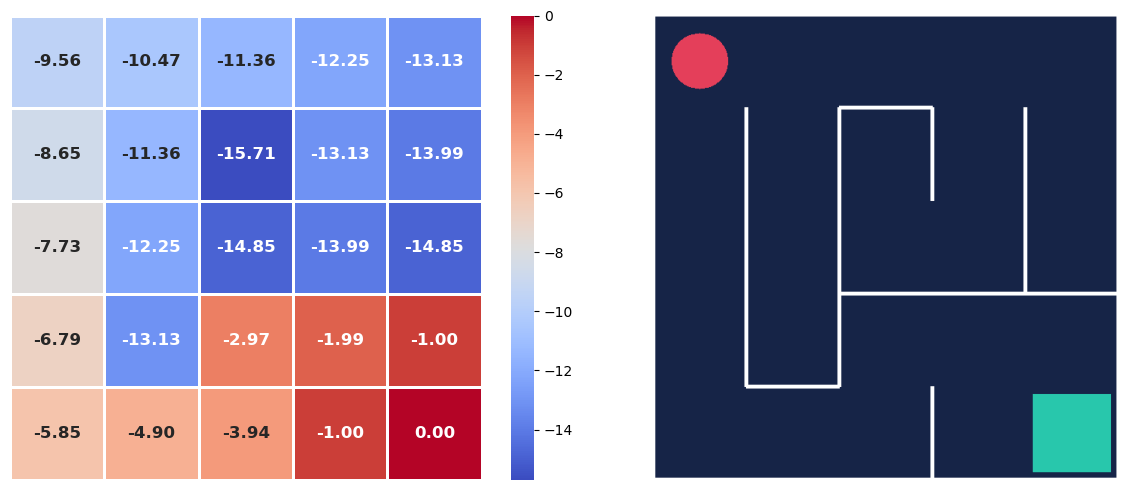

In [16]:
plot_values(opt_value , frame)

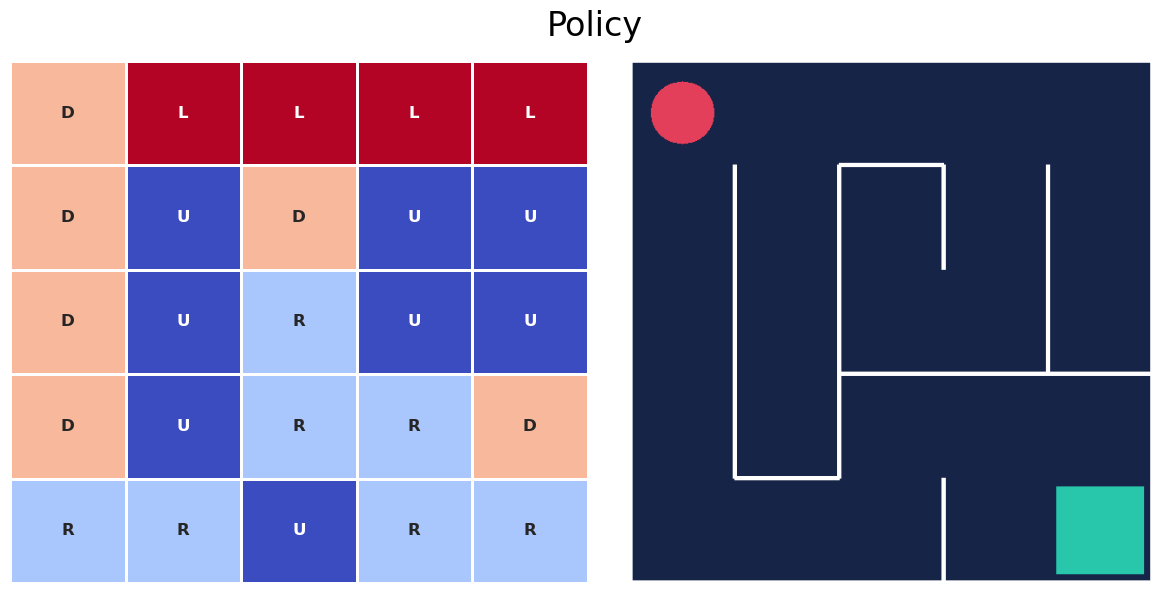

In [17]:
plot_policy (opt_policy , frame)

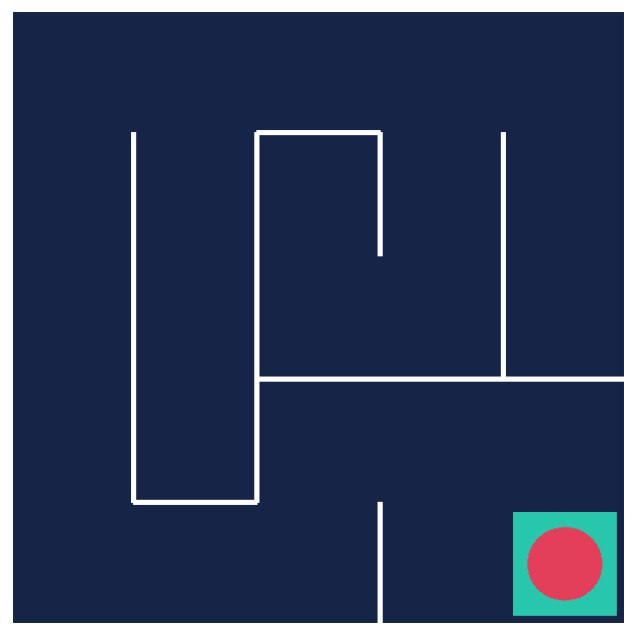

In [18]:
## test the agent with optimal policy
test_agent(env , policy , episodes=1)

In [19]:
env.close()

# Policy Iteration

In [20]:
env = Maze()
state = env.reset()

In [21]:
def policy_eval(policy_probs , state_values , theta=1e-6 , gamma=0.99):
    delta = float('inf')
    while delta > theta :
        delta=0
        for row in range(5):
            for col in range(5):
                old_value=state_values[(row,col)]
                new_value=0
                action_probs = policy_probs[(row,col)]
                for action,prob in enumerate(action_probs):
                    next_state , reward , _ , _ = env.simulate_step((row,col) , action)
                    new_value = new_value + prob * (reward + gamma*state_values[next_state])
                state_values[(row,col)] = new_value
                delta = max(delta , abs(old_value-new_value))
    
    return state_values

def policy_imp(policy_probs , state_values , gamma=0.99):
    policy_stable=True
    for row in range(5):
        for col in range(5):
            old_action = policy_probs[(row,col)].argmax()
            
            new_action=None
            max_qsa = float("-inf")
            
            for action in range(4):
                next_state , reward , _ , _ = env.simulate_step((row,col) , action)
                qsa = reward + gamma * state_values[next_state]
                
                if qsa > max_qsa:
                    max_qsa = qsa
                    new_action=action
                    
            
            action_probs = np.zeros(4)
            action_probs[new_action]=1
            policy_probs[(row,col)] = action_probs
            
            if new_action != old_action :
                policy_stable = False
    
    return policy_stable , policy_probs

def policy_itr(policy_probs , state_values , theta = 1e-6 , gamma = 0.99):
    policy_stable = False
    while policy_stable == False :
        state_values = policy_eval(policy_probs , state_values , theta , gamma)
        plot_values(state_values , frame)
        policy_stable , policy_probs = policy_imp(policy_probs , state_values , gamma)
        plot_policy(policy_probs , frame)
    return policy_probs , state_values

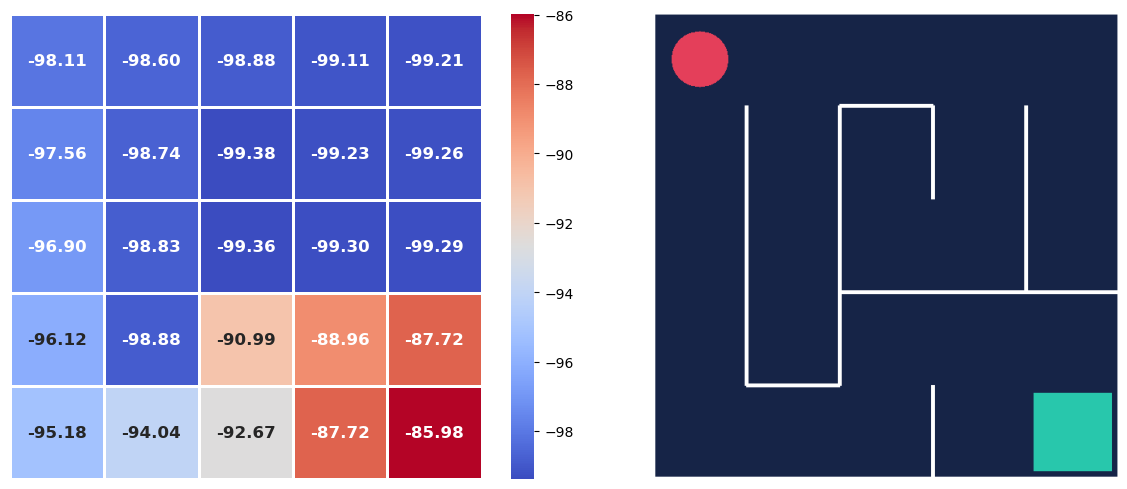

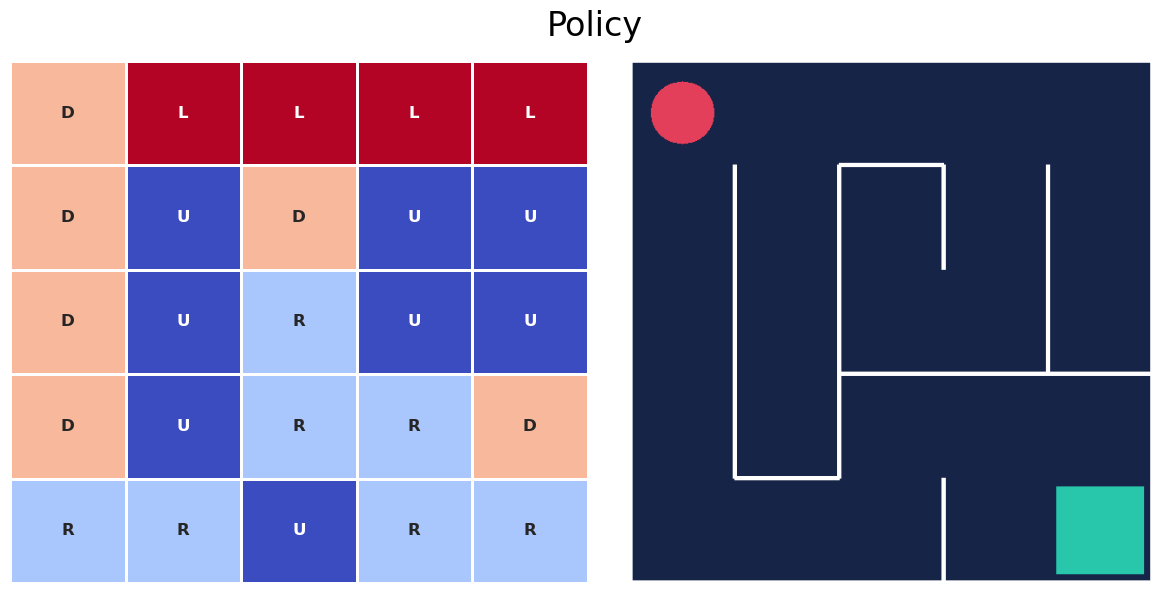

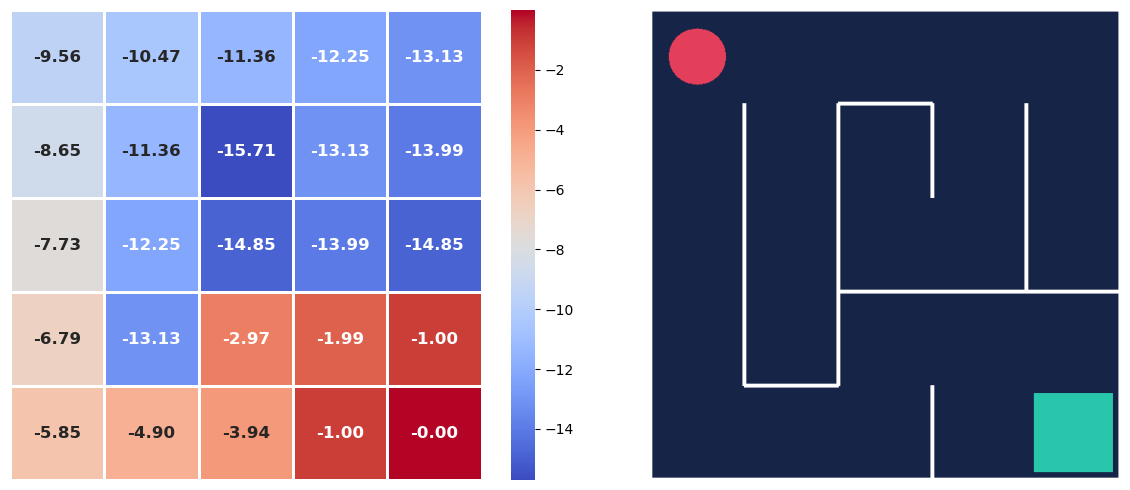

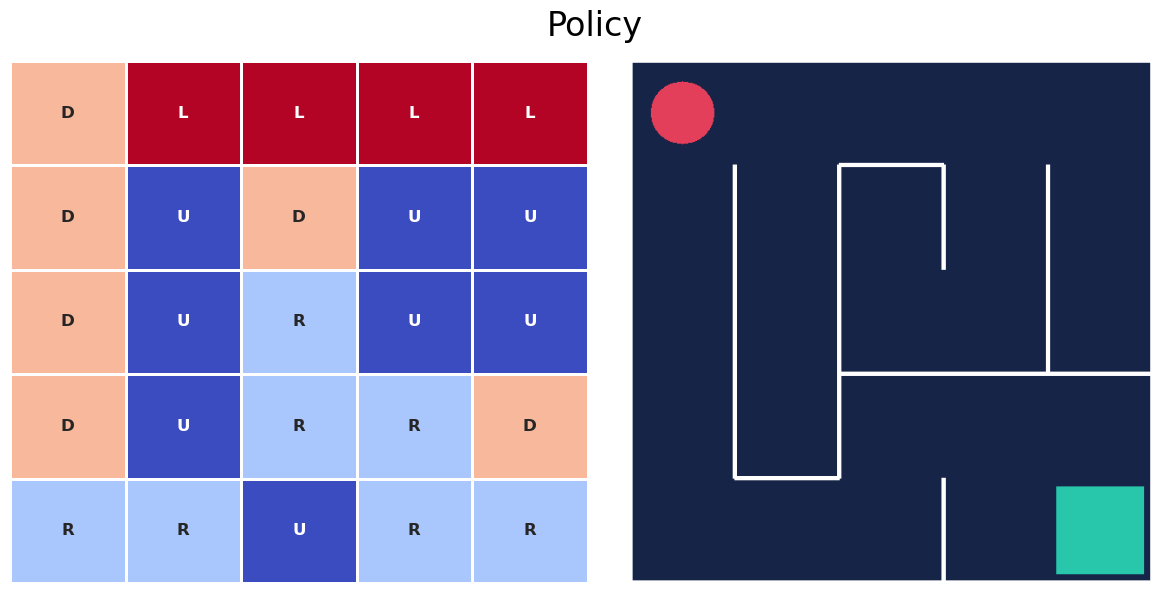

In [22]:
env = Maze()
state = env.reset()
frame = env.render(mode='rgb_array')
policy_probs = np.full ((5,5,4) , 0.25)
state_values = np.zeros((5,5))
policy_probs , state_values = policy_itr(policy_probs , state_values)

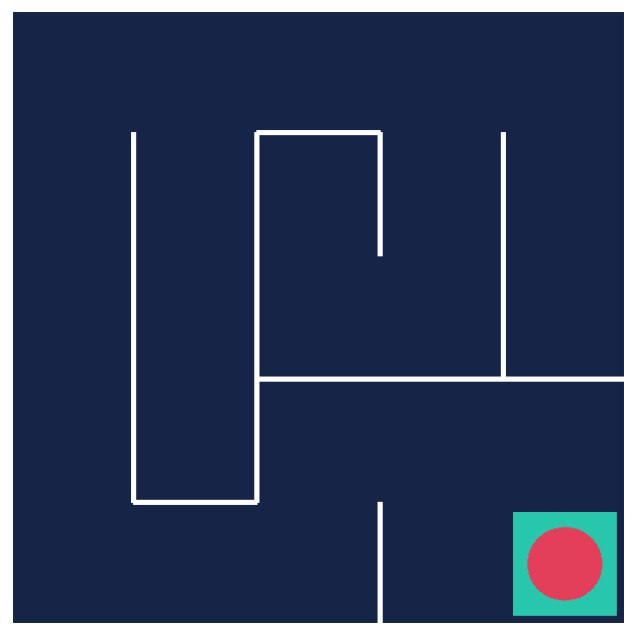

In [23]:
## test agent :
test_agent(env , policy)

# On-policy Monte Carlo Method

In [24]:
env = Maze()
state = env.reset()
frame = env.render(mode='rgb_array')

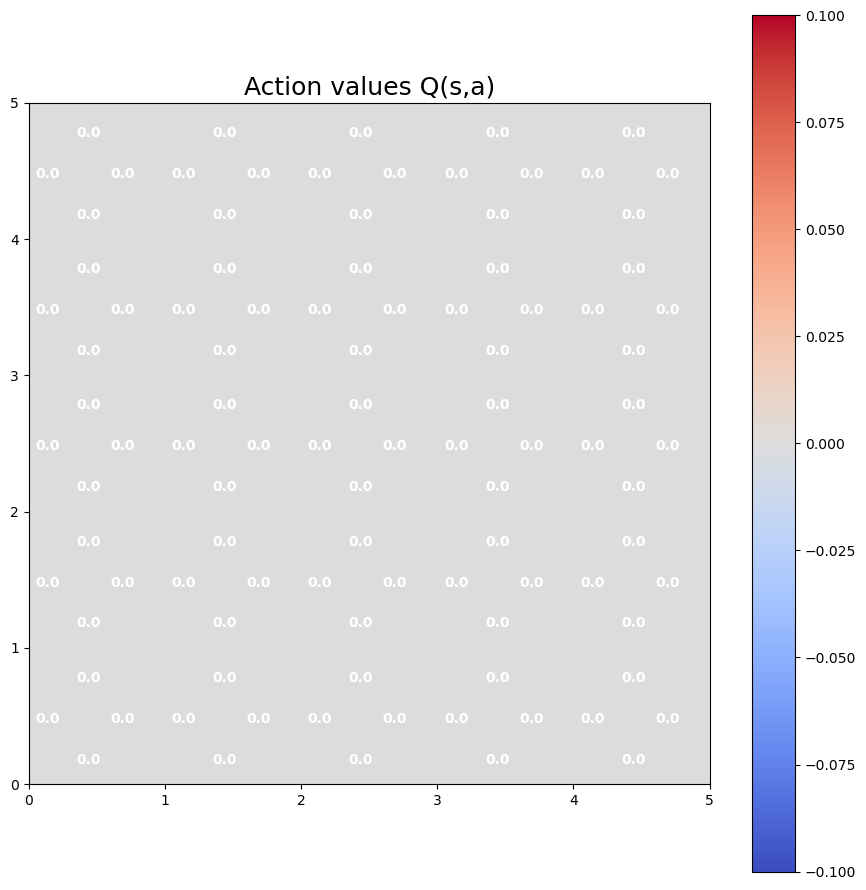

In [25]:
action_values = np.zeros((5,5,4))
plot_action_values(action_values)

In [26]:
def policy(state , epsilon=0.2):
    if np.random.random() < epsilon:
        return np.random.choice(4)
    else:
        av = action_values[state]
        return np.random.choice(np.flatnonzero(av==av.max()))

In [27]:
def onPolicy(policy , action_values , episodes , gamma = 0.99 , epsilon=0.2):
    sa_returns={}
    for episode in range( 1 , episodes+1):
        state = env.reset()
        done=False
        transition=[]
        while not done:
            action = policy(state,epsilon)
            next_state , reward , done , _ = env.step(action)
            transition.append([state,action,reward])
            state = next_state
        G=0
        for state_t , action_t , reward_t in reversed(transition):
            G = reward_t + gamma*G
            
            if not (state_t , action_t) in sa_returns:
                sa_returns[(state_t , action_t)] = []
            sa_returns[(state_t , action_t)].append(G)
            
            action_values[state_t][action_t] = np.mean(sa_returns[(state_t , action_t)])
    return action_values

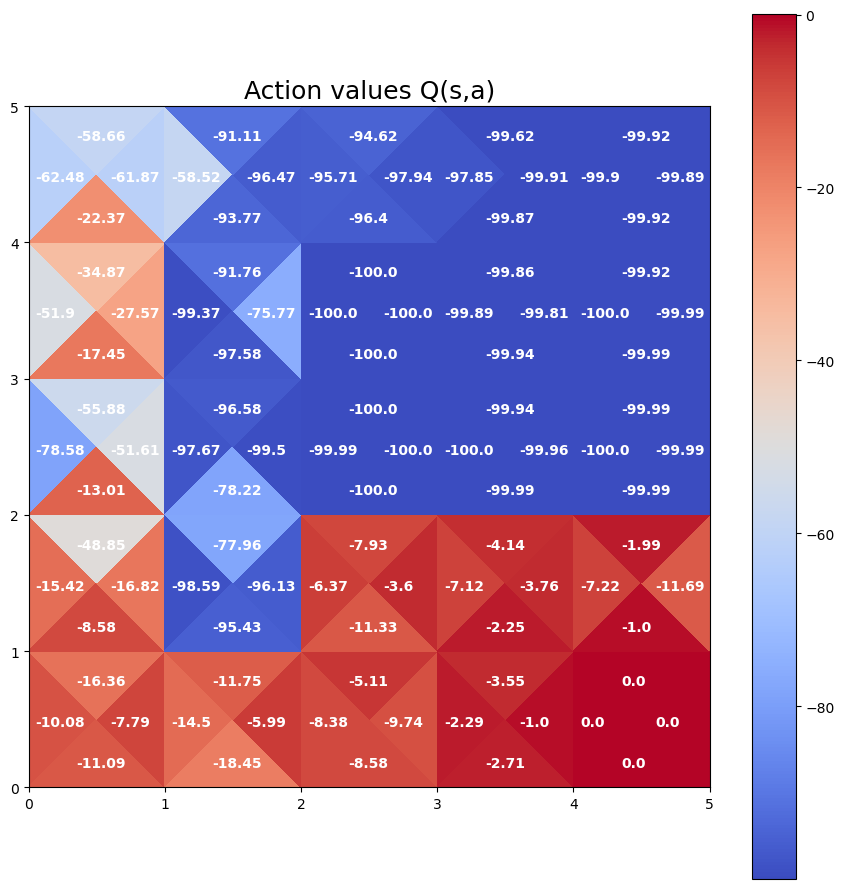

In [28]:
action_values = np.zeros((5,5,4))
action_values = onPolicy(policy , action_values , 300)
plot_action_values(action_values)

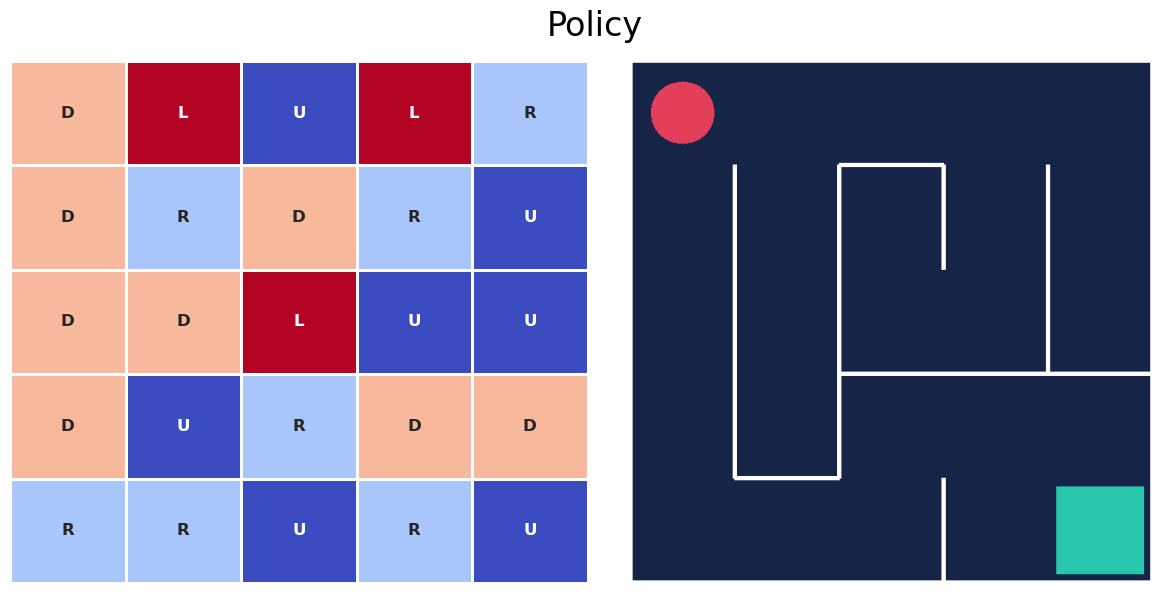

In [29]:
plot_policy(action_values , frame)

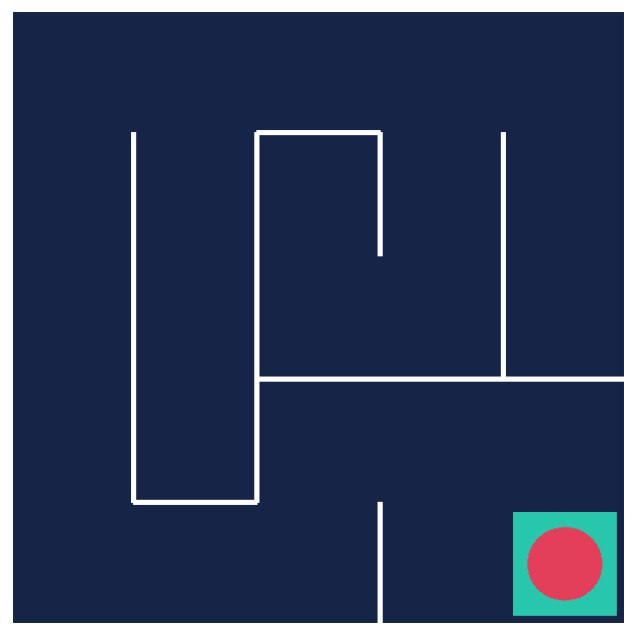

In [30]:
test_agent(env , policy)

In [31]:
def onPolicy_alpha(policy , action_values , episodes , gamma = 0.99 , epsilon=0.2 , alpha = 0.2):
    for episode in range( 1 , episodes+1):
        state = env.reset()
        done=False
        transition=[]
        while not done:
            action = policy(state,epsilon)
            next_state , reward , done , _ = env.step(action)
            transition.append([state,action,reward])
            state = next_state
        G=0
        for state_t , action_t , reward_t in reversed(transition):
            G = reward_t + gamma*G
            action_values[state_t][action_t] = action_values[state_t][action_t] + alpha*(G - action_values[state_t][action_t])
    return action_values

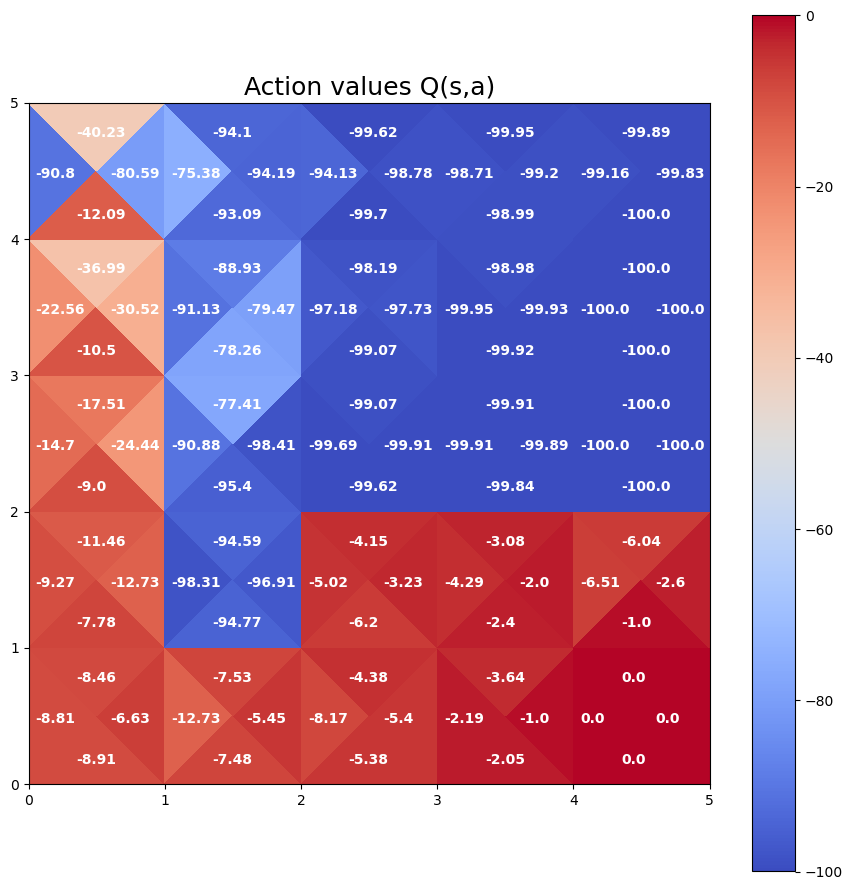

In [34]:
env.close()
env = Maze()
action_values = np.zeros((5,5,4))
action_values = onPolicy_alpha(policy , action_values , 300)
plot_action_values(action_values)

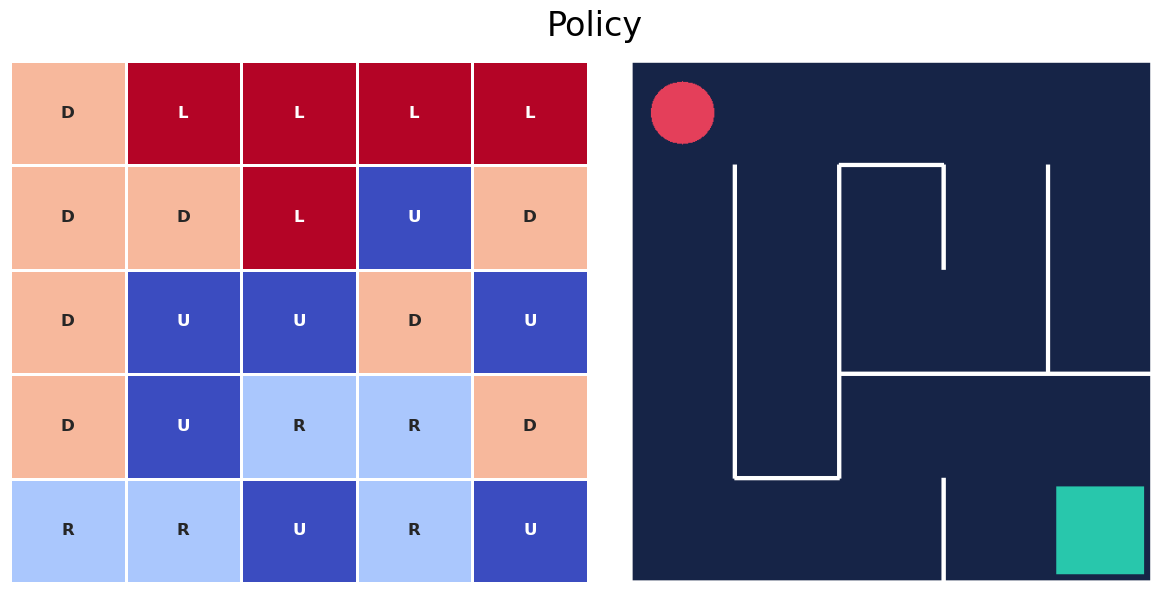

In [35]:
plot_policy(action_values , frame)

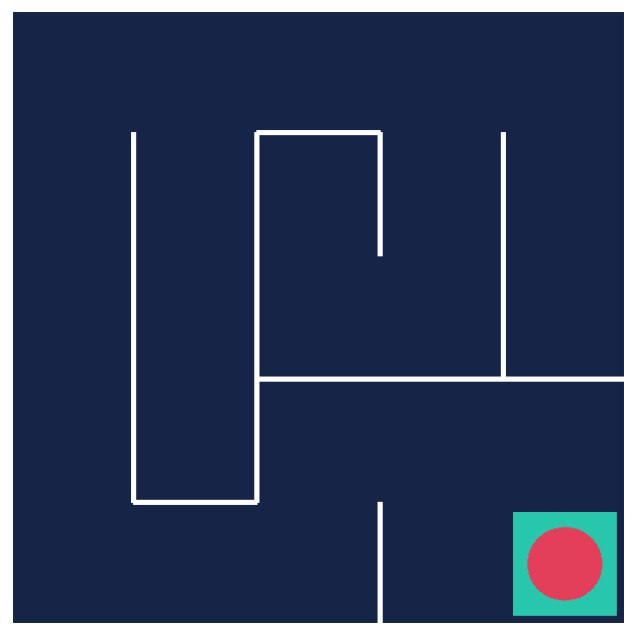

In [36]:
test_agent(env , policy)

# Off-policy Monte Carlo Method

In [46]:
env = Maze()
frame = env.render(mode='rgb_array')

In [49]:
def target_policy(state):
    av = action_values[state]
    return np.random.choice(np.flatnonzero(av==av.max()))

def exploratory_policy(state , epsilon):
    if np.random.random() < epsilon:
        return np.random.choice(4)
    else:
        av = action_values[state]
        return np.random.choice(np.flatnonzero(av==av.max()))
    
def offPolicy(action_values , target_policy , exploratory_policy  , episodes , gamma = 0.99 , epsilon=0.2):
    csa = np.zeros((5,5,4))
    for episode in range(1,episodes+1):
        G = 0
        W = 1
        state = env.reset()
        done = False
        transitions=[]
        while not done :
            action = exploratory_policy(state , epsilon)
            next_state , reward , done , _ = env.step(action)
            transitions.append([state,action , reward])
            state = next_state
        for state_t , action_t , reward_t in reversed(transitions):
            G = reward_t + gamma * G
            csa[state_t][action_t] = csa[state_t][action_t]+ W
            action_values[state_t][action_t] =action_values[state_t][action_t]+ (W/csa[state_t][action_t])*(G-action_values[state_t][action_t])
            A_t = target_policy(state_t)
            if A_t != action_t :
                break
            W = W / (1-epsilon+(epsilon/4))
    return action_values    

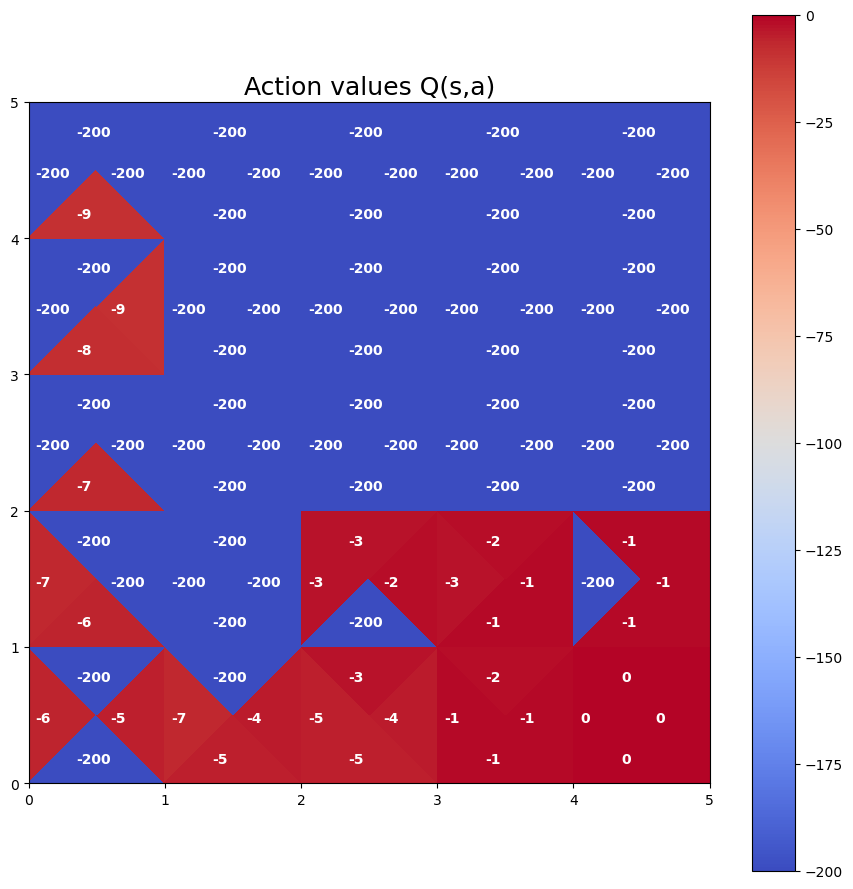

In [53]:
action_values = np.full((5,5,4),-200)
action_values[(4,4)][:]=0
action_values = offPolicy(action_values , target_policy , exploratory_policy  , episodes=100 , epsilon=0.4)
plot_action_values(action_values)

C:\Users\Ali\Documents\RLwithPhil\code\utils.py:23: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  probs_copy = max_prob_actions.copy().astype(np.object)


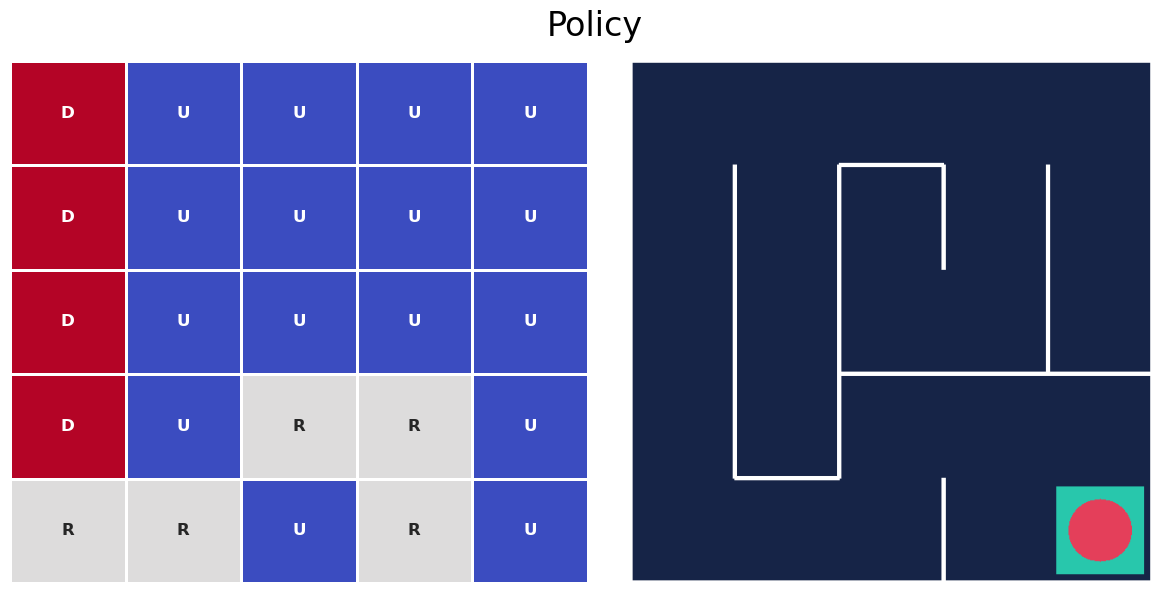

In [54]:
plot_policy(action_values , frame)

# SARSA

In [32]:
def policy(state , epsilon=0.2):
    if np.random.random() < epsilon:
        return np.random.choice(4)
    else:
        av = action_values[state]
        return np.random.choice(np.flatnonzero(av==av.max()))

def sarsa(action_values , policy , episodes , alpha=0.2 , gamma=0.99 , epsilon = 0.25):
    for episode in range(1 , episodes+1):
        state = env.reset()
        action = policy(state , epsilon)
        done=False
        while not done:
            next_state , reward , done , _ = env.step(action)
            next_action = policy(next_state , epsilon)
            qsa_t = action_values[state][action]
            qsa_t_prime = action_values[next_state][next_action] 
            action_values[state][action] = qsa_t + alpha*(reward + gamma * qsa_t_prime - qsa_t)
            state = next_state
            action = next_action
            
    return action_values

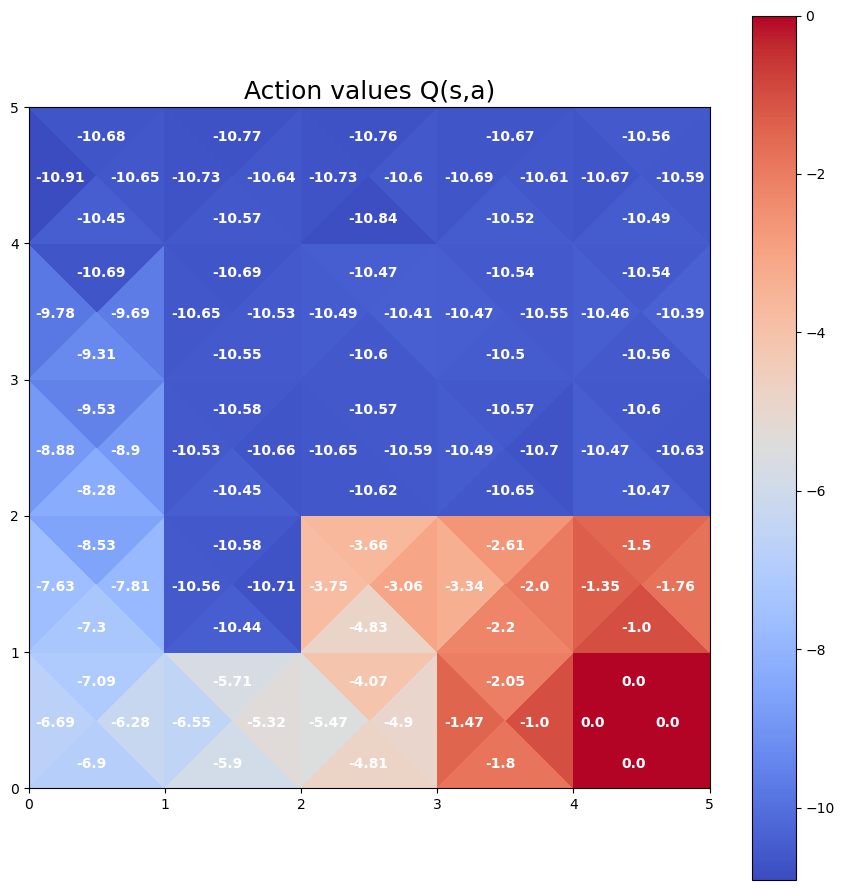

In [33]:
env = Maze()
frame = env.render(mode='rgb_array')
action_values = np.zeros((5,5,4))
action_values = sarsa(action_values , policy , 100 )
plot_action_values(action_values)

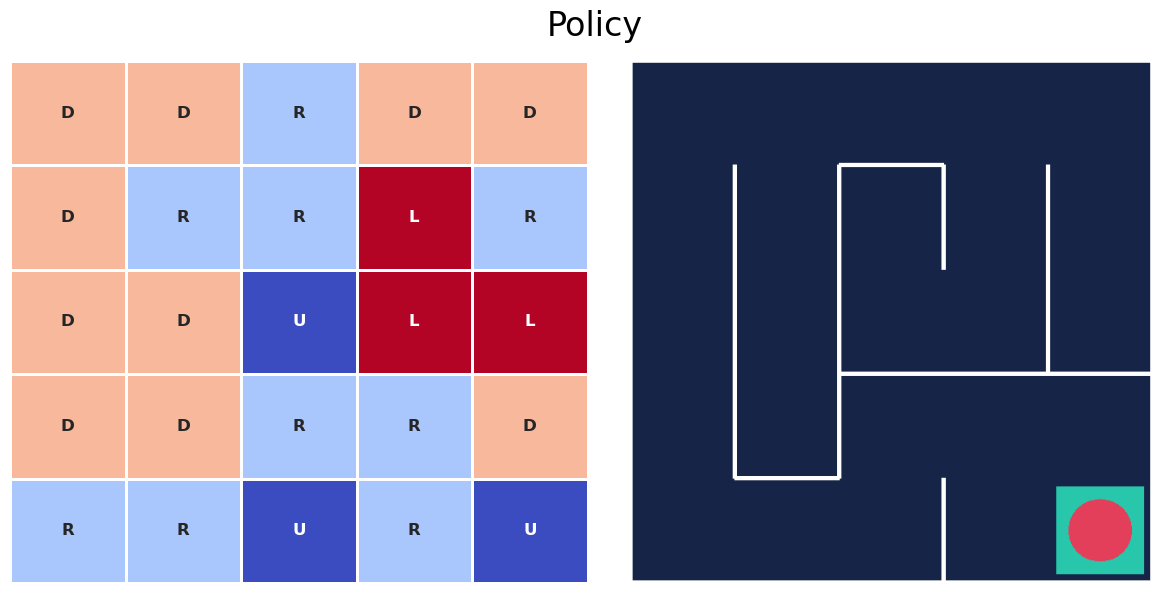

In [34]:
plot_policy(action_values , frame)

# Q-Learning

In [41]:
def target_policy(state):
    av = action_values[state]
    return np.random.choice(np.flatnonzero(av==av.max()))

def exploratory_policy(state , epsilon):
    if np.random.random() < epsilon:
        return np.random.choice(4)
    else:
        av = action_values[state]
        return np.random.choice(np.flatnonzero(av==av.max()))
    
def Qlearning(action_values , exploratory_policy , target_policy , episodes , alpha=0.2 , gamma=0.99 , epsilon = 0.25):
    for episode in range(1 , episodes+1):
        state = env.reset()
        done=False
        while not done:
            action = exploratory_policy(state , epsilon)
            next_state , reward , done , _ = env.step(action)
            next_action = target_policy(next_state)
            qsa_t = action_values[state][action]
            qsa_t_prime = action_values[next_state][next_action] 
            action_values[state][action] = qsa_t + alpha*(reward + gamma * qsa_t_prime - qsa_t)
            state = next_state
            
    return action_values

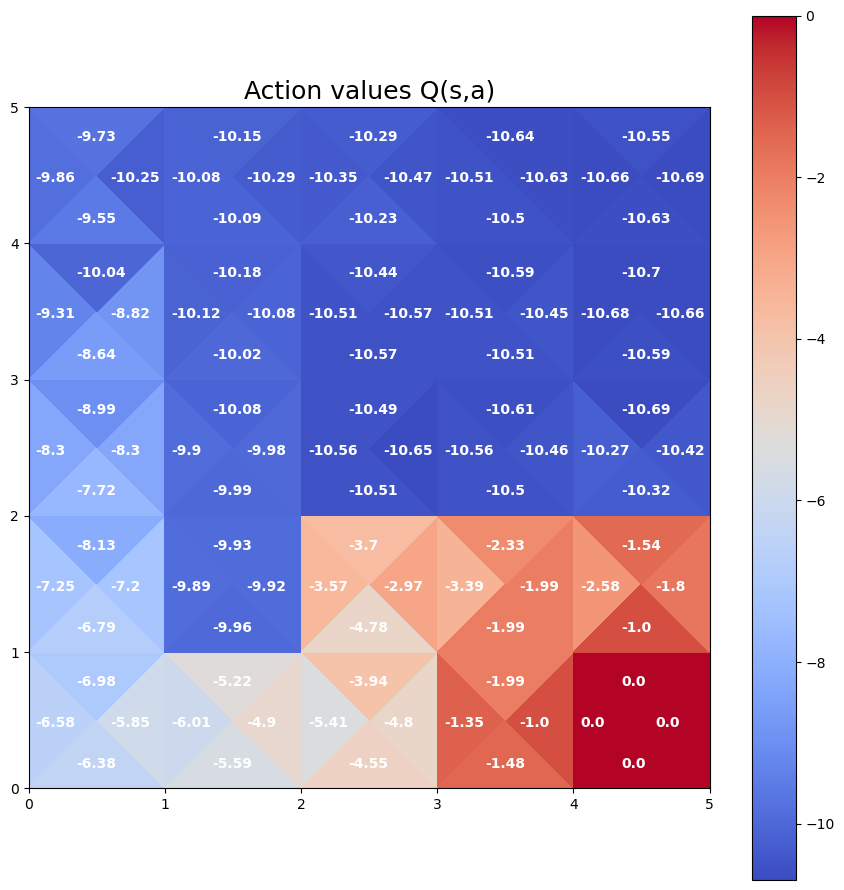

In [42]:
env = Maze()
frame = env.render(mode='rgb_array')
action_values = np.zeros((5,5,4))
action_values = Qlearning(action_values , exploratory_policy , target_policy ,100)
plot_action_values(action_values)

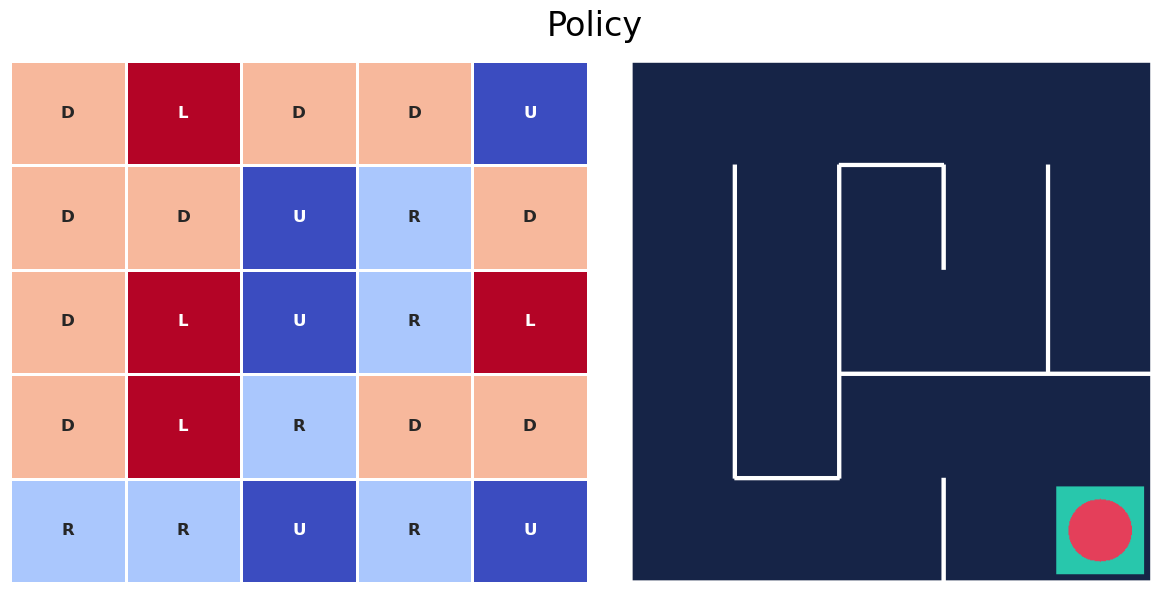

In [43]:
plot_policy(action_values , frame)

# n-step SARSA

In [51]:
def policy(state , epsilon=0.2):
    if np.random.random() < epsilon:
        return np.random.choice(4)
    else:
        av = action_values[state]
        return np.random.choice(np.flatnonzero(av==av.max()))

def n_step_sarsa(action_values , policy , episodes , alpha=0.2 , gamma=0.99 , epsilon = 0.25 , n=10):
    for episode in range(1 , episodes+1):
        state = env.reset()
        action = policy(state , epsilon)
        transitions=[]
        done=False
        t = 0
        while t-n < len(transitions) :
            if not done :
                next_state , reward , done , _ = env.step(action)
                next_action = policy (next_state , epsilon)
                transitions.append([state , action , reward])
            if t>=n:
                G = (1-done)*action_values[next_state][next_action]
                for state_t , action_t , reward_t in reversed(transitions[t-n:]):
                    G = reward_t + gamma * G
                action_values[state_t][action_t] = action_values[state_t][action_t] + alpha*(G-action_values[state_t][action_t])
            t=t+1
            state = next_state
            action = next_action
    return action_values

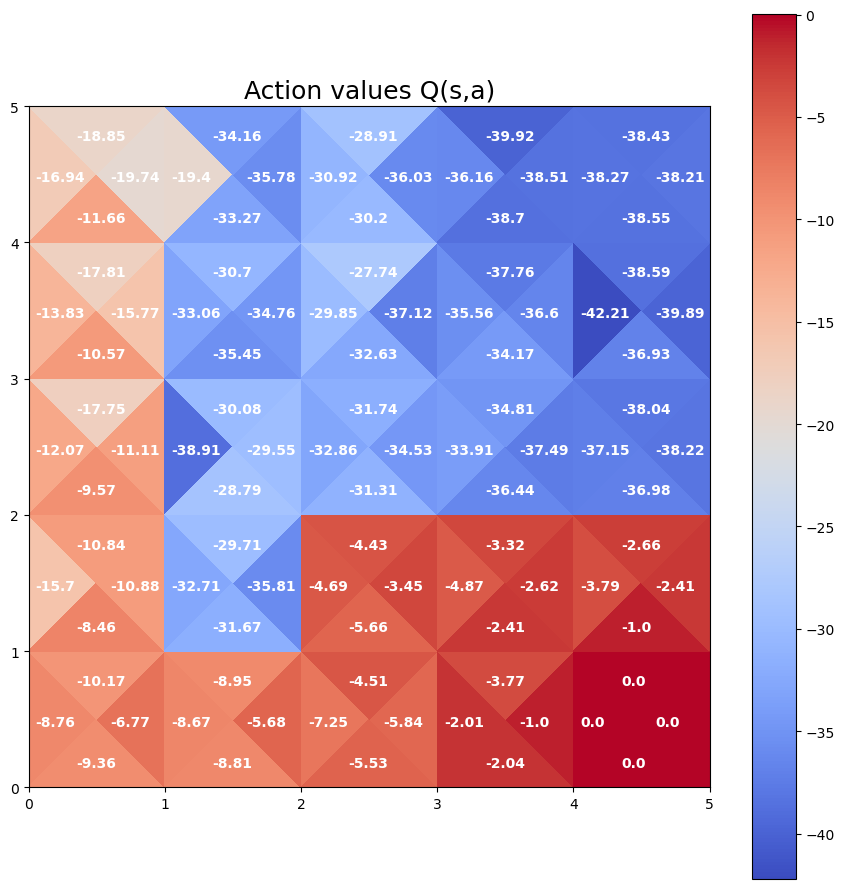

In [52]:
env = Maze()
frame = env.render(mode='rgb_array')
action_values = np.zeros((5,5,4))
action_values = n_step_sarsa(action_values , policy , 1000 )
plot_action_values(action_values)

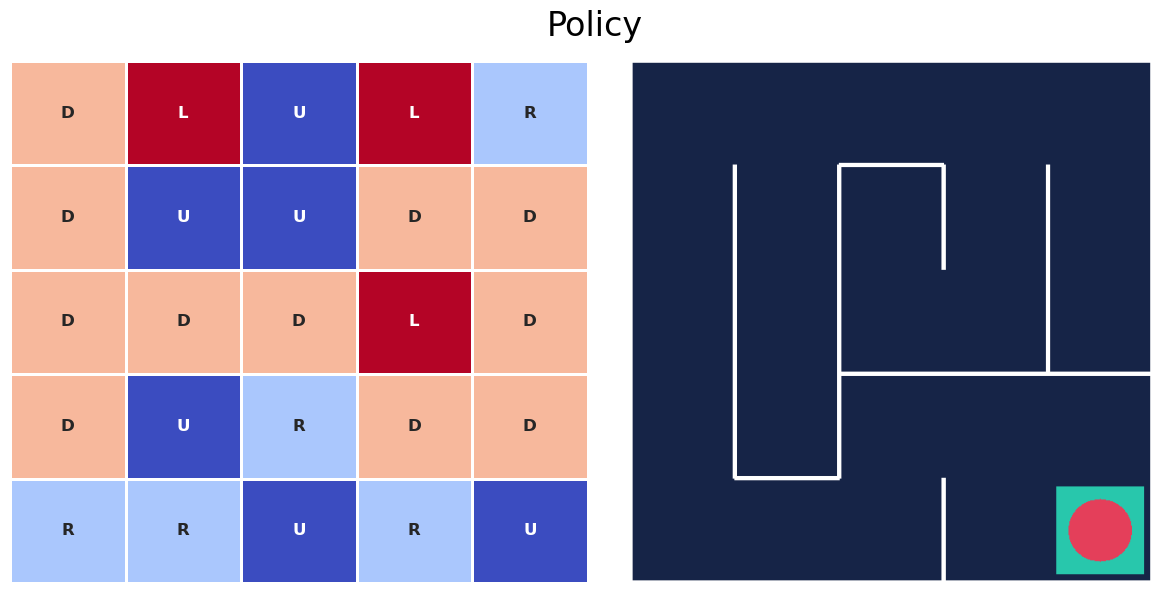

In [53]:
plot_policy(action_values , frame)